<a href="https://colab.research.google.com/github/Jimmynycu/Monte_Carlo/blob/main/Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.61
    Uninstalling yfinance-0.2.61:
      Successfully uninstalled yfinance-0.2.61


In [ ]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf

<ipython-input-8-1032055548>:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stockData = yf.download(stocks, start=start, end=end)
[*********************100%***********************]  6 of 6 completed


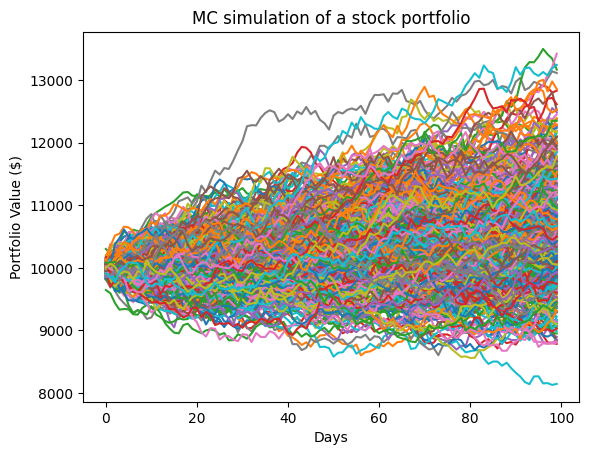

VaR_5 $843.52
CVaR_5 $1058.1


In [ ]:
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)
    if stockData is None or stockData.empty:
        print("Could not retrieve data for the specified stocks and date range.")
        return None, None
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

if meanReturns is not None and covMatrix is not None:
    weights = np.random.random(len(meanReturns))
    weights /= np.sum(weights)

    # Monte Carlo Method
    mc_sims = 400 # number of simulations
    T = 100 #timeframe in days

    meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
    meanM = meanM.T

    portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

    initialPortfolio = 10000

    for m in range(0, mc_sims):
        Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
        L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
        dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
        portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

    plt.plot(portfolio_sims)
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Days')
    plt.title('MC simulation of a stock portfolio')
    plt.show()

    def mcVaR(returns, alpha=5):
        """ Input: pandas series of returns
            Output: percentile on return distribution to a given confidence level alpha
        """
        if isinstance(returns, pd.Series):
            return np.percentile(returns, alpha)
        else:
            raise TypeError("Expected a pandas data series.")

    def mcCVaR(returns, alpha=5):
        """ Input: pandas series of returns
            Output: CVaR or Expected Shortfall to a given confidence level alpha
        """
        if isinstance(returns, pd.Series):
            belowVaR = returns <= mcVaR(returns, alpha=alpha)
            return returns[belowVaR].mean()
        else:
            raise TypeError("Expected a pandas data series.")


    portResults = pd.Series(portfolio_sims[-1,:])

    VaR = initialPortfolio - mcVaR(portResults, alpha=5)
    CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

    print('VaR_5 ${}'.format(round(VaR,2)))
    print('CVaR_5 ${}'.format(round(CVaR,2)))